In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
from copy import deepcopy
import datetime

In [166]:
pd.set_option('display.max_rows', 1000)

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, TensorDataset

In [4]:
cwd = os.getcwd()
print(cwd)
# cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/opt/data/chemprop_run/git/notebooks/AltModels
/opt/data/chemprop_run/git


In [5]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [8]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [9]:
n_gpu = torch.cuda.device_count()
n_gpu

5

In [10]:
device_cpu = get_device(to_gpu=False)
# device_gpu = get_device(True, index=0)

# fdtype = torch.float32

In [11]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


### Preparing dataset 

In [12]:
score = 'total_thresh' #'total_thresh'
score_val = 4

In [13]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

# v_1: GNN
# v_2: Alt Models (Baseline)
data_fname = 'data_v2'

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
print(targetdata_dir)

path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
/opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2


In [15]:
xFlat = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X_flat.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))
expression = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [16]:
xFlatMat = torch.stack([torch.cat(i) for i in list(xFlat.values())])
xFlatMat.shape

torch.Size([25757, 18])

In [17]:
torch.tensor(expression)

tensor([[ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        [ 0.1661,  0.2518,  1.3373,  ..., -0.4085,  0.8581,  0.8979],
        ...,
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537],
        [-0.0373, -1.4322,  1.5411,  ..., -1.2711,  1.2013,  0.9537]],
       dtype=torch.float64)

In [18]:
x = torch.cat([xFlatMat, torch.tensor(expression)], dim=1)
x.shape

torch.Size([25757, 926])

In [19]:
y

array([0, 0, 0, ..., 0, 1, 1])

In [20]:
x.shape

torch.Size([25757, 926])

In [21]:
y.shape

(25757,)

In [22]:
fold_partitions = get_stratified_partitions(y,
                                            num_folds=5,
                                            valid_set_portion=0.1,
                                            random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.5764356969533567
class: 1 norm count: 0.4235643030466433
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5763929334109882
class: 1 norm count: 0.4236070665890118

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.576

In [23]:
print("Number of training graphs: "+ str(len(fold_partitions[0]['train'])))
print("Number of validation graphs: "+ str(len(fold_partitions[0]['validation'])))
print("Number of testing graphs: "+ str(len(fold_partitions[0]['test'])))


Number of training graphs: 18544
Number of validation graphs: 2061
Number of testing graphs: 5152


### Preprocessing

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
x_np = x.numpy()
y_np = y

In [26]:
pipeline = compose(scaler.fit_transform, np.tanh, scaler.fit_transform)

In [27]:
x_np_norm = pipeline(x_np)

In [28]:
deepsynergy_input_size = x_np_norm.shape[1]
deepsynergy_input_size

926

In [29]:
ids = list(range(len(y)))

In [30]:
dataset = TensorDataset(torch.tensor(x_np_norm),torch.tensor(y), torch.tensor(ids))
dataset

In [31]:
x_np_norm.shape

(25757, 926)

In [32]:
fold_partitions[0]['test']

array([    4,    13,    16, ..., 25731, 25743, 25753])

### Deep Synergy

In [33]:
# training params total_thresh 4
tp = {
    "batch_size" : 300,
    "num_epochs" : 100,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "gene_embed_dim": 1,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
#     "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "base_lr" : 3e-5, #3e-4
    "max_lr_mul": 5,
    "l2_reg" : 1e-5,
    "loss_w" : 1.,
    "margin_v" : 1.,

    "expression_dim" : 64,
    "expression_input_size" : 908,
    "exp_H1" : 8192,
    "exp_H2" : 4096
}

In [34]:
tp['deepsynergy_input_size'] = deepsynergy_input_size
tp['deepsynergy_input_size']

926

In [35]:
def spawn_q_process(q_process):
    print(">>> spawning hyperparam search process")
    q_process.start()
    
def join_q_process(q_process):
    q_process.join()
    print("<<< joined hyperparam search process")
    
def create_q_process(queue, used_dataset, gpu_num, tphp, exp_dir, partition): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_exp_flat, args=(queue, used_dataset, gpu_num, tphp, exp_dir, partition)) #

def create_q_process_attr(queue, x_np_norm, gpu_num, tphp, exp_dir, partition, labels): #
#     fold_gpu_map = {0:gpu_num}
    return mp.Process(target=deepadr.hyphelperflat.run_attribution, args=(queue, x_np_norm, gpu_num, tphp, exp_dir, partition, labels)) #

In [36]:
# import torch.multiprocessing as mp
# mp.set_start_method("spawn", force=True)

# queue = mp.Queue()
# q_processes = []

# # partition = fold_partitions[0]
# time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print("Start: " + time_stamp)

# for q_i in range(min(n_gpu, len(fold_partitions))):
# #     device_gpu = get_device(True, index=q_i)
#     partition = fold_partitions[q_i]
#     exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
#     create_directory(os.path.join(exp_dir, "predictions"))
#     create_directory(os.path.join(exp_dir, "modelstates"))

# #     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
#     q_process = create_q_process(queue, dataset, q_i, tp, exp_dir, partition)
#     q_processes.append(q_process)
#     spawn_q_process(q_process)

# spawned_processes = n_gpu
    
# # for q_i in range(len(hyperparam_space)):
# for q_i in range(min(n_gpu, len(fold_partitions))):
#     join_q_process(q_processes[q_i])
#     released_gpu_num = queue.get()
#     print("released_gpu_num:", released_gpu_num)
# #     if(spawned_processes < len(hyperparam_space)):
# # #         device_gpu = get_device(True, index=q_i)
# #         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# #         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
# #         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

# #         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
# #         q_processes.append(q_process)
# #         spawn_q_process(q_process)
# #         spawned_processes = spawned_processes + 1

In [37]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-24_12-07-37


### Get Predictions

In [38]:
time_stamp = '2022-06-22_16-02-28'

In [39]:
import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

5

In [40]:
best_epoch = 99

In [41]:
print("best epoch:", best_epoch)

l_pred = []

for edir in exp_dirs:
    predictions = pd.read_csv(edir + f"/predictions/epoch_{best_epoch}_predictions_test.csv")
    l_pred.append(predictions)

best epoch: 99


In [42]:
l_pred[0]

,id,true_class,pred_class,prob_score_class0,prob_score_class1
0,10,0.0,1,0.478081,5.219193e-01
1,12,1.0,0,0.868957,1.310435e-01
2,17,0.0,0,1.000000,1.058048e-10
3,28,1.0,1,0.153701,8.462992e-01
4,35,0.0,0,0.986174,1.382562e-02
...,...,...,...,...,...
5146,25737,1.0,1,0.000620,9.993798e-01
5147,25744,1.0,1,0.000002,9.999983e-01
5148,25745,1.0,1,0.003959,9.960411e-01
5149,25747,1.0,1,0.021445,9.785548e-01


In [43]:
df_pred = pd.concat(l_pred, axis=0).astype({"id":int, "true_class":int}).set_index("id")
df_pred

,true_class,pred_class,prob_score_class0,prob_score_class1
id,,,,
10,0,1,0.478081,5.219193e-01
12,1,0,0.868957,1.310435e-01
17,0,0,1.000000,1.058048e-10
28,1,1,0.153701,8.462992e-01
35,0,0,0.986174,1.382562e-02
...,...,...,...,...
25735,0,0,0.948470,5.152988e-02
25741,1,1,0.000873,9.991272e-01
25742,1,1,0.000433,9.995673e-01


In [44]:
# df_pred.sort_index()

### Get Drug and Cell Line names

In [45]:
data_pairs = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))
data_pairs

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
25752,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [46]:
df_all = pd.concat([df_pred.sort_index(), data_pairs], axis=1)
df_all

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,1,0,0.999247,0.000753,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,0,1,0.000050,0.999950,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...,...,...,...,...
25752,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,0,1,0.390352,0.609648,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,1,0,0.991512,0.008488,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [47]:
df_pred_TP = df_all[((df_all.true_class == 0) & (df_all.pred_class == 0)) |
                     ((df_all.true_class == 1) & (df_all.pred_class == 1))]
df_pred_TP

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
6,1,1,0.010439,0.989561,AT7519,PF-3758309,TC-71,1240221,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
7,1,1,0.000052,0.999948,ZINC34894448,PF-3758309,TC-71,1240221,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
...,...,...,...,...,...,...,...,...,...,...,...
25750,0,0,0.976813,0.023187,AZD7762,AZD6738,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC(=C2)C3(CC3)S(=N)(=O)C)C4=C5...,0
25751,0,0,0.989993,0.010007,AZD7762,AZD4547,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1CN(CC(N1)C)C2=CC=C(C=C2)C(=O)NC3=NNC(=C3)CC...,0
25752,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0


In [48]:
df_pred_TP.index.values

array([    0,     1,     2, ..., 25752, 25753, 25756])

In [49]:
df_pred_TP_RI = df_pred_TP.reset_index()

df_pred_TP_zeros = df_pred_TP_RI[df_pred_TP_RI.true_class == 0].index
df_pred_TP_ones = df_pred_TP_RI[df_pred_TP_RI.true_class == 1].index

In [50]:
len(df_pred_TP_zeros) + len(df_pred_TP_ones)

21018

In [170]:
df_pred_TP.Cell_Line_ID.value_counts()

COLO 800      1180
A101D          973
LOX IMVI       840
RVH-421        820
WM115          787
SKMEL30        765
UACC62         755
SK-MEL-28      735
A2058          677
A375           606
MeWo           578
T98G           571
RPMI7951       558
COLO 792       556
IPC-298        529
SK-MEL-2       524
Mel Ho         522
COLO 829       520
G-361          507
SK-MEL-5       486
MZ-MEL-2       464
IST-MEL1       432
UACC-257       426
LB2518-MEL     423
451Lu          385
HL-60(TB)      199
SR             183
RPMI-8226      166
HT29           164
MDA-MB-468     161
KM12           152
A2780          139
MOLT-4         135
CCRF-CEM       132
NCI-H522       131
HCT116         129
SF-539         126
CAKI-1         122
K-562          120
786-0          118
T-47D          112
OVCAR3         110
COLO 205       105
HCC-2998       104
SK-OV-3        103
RKO             96
OVCAR-8         93
SW-620          92
BT-549          90
PA1             88
NCIH23          87
DU-145          87
ACHN        

In [141]:
df_pred_TP[df_pred_TP.true_class ==1].Cell_Line_ID.value_counts()

T98G         571
A375         454
A2058        377
MZ-MEL-2     349
RVH-421      337
            ... 
HT-1197        1
KU-19-19       1
NCI-H1975      1
NCI-H2126      1
VM-CUB-1       1
Name: Cell_Line_ID, Length: 142, dtype: int64

In [142]:
df_pred_TP[df_pred_TP.true_class ==1].Drug1_ID.value_counts()

vincristine      486
Navitoclax       460
Daporinad        280
docetaxel        202
Sunitinib        196
                ... 
capmatinib         1
indapamide         1
Indirubin          1
iOWH-032           1
CHEMBL3348822      1
Name: Drug1_ID, Length: 759, dtype: int64

In [216]:
df_pred_TP[df_pred_TP.true_class ==1].Drug2_ID.value_counts()

temozolomide                           626
actinomycin D                          337
MITHRAMYCIN                            259
915019-65-7                            166
841290-80-0                            159
Deforolimus                            150
Lapatinib                              147
Tipifarnib                             145
Dasatinib                              144
Erlotinib                              133
docetaxel                              132
RAF265                                 117
934593-90-5                            116
891494-63-6                            115
BI-D1870                               112
Sorafenib                              112
Veliparib                              111
MK-1775                                110
OSU-03012                              108
MK-2206                                 98
Cardamonin                              96
BMS-536924                              96
SNS-032                                 94
ADM hydroch

In [217]:
sel_CellLine = "COLO 800"
sel_Drug1_ID = "Navitoclax"
sel_Drug2_ID = "Silmitasertib" # Silmitasertib  Decitabine Dovitinib Fludarabine Cediranib
 

In [218]:
df_pred_TP_CellLine = df_pred_TP[df_pred_TP.Cell_Line_ID == sel_CellLine]
df_pred_TP_CellLine.head(100)

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
17306,0,0,0.799202,0.200798,844499-71-4,KU-55933,COLO 800,906813,C1=CC=C(C(=C1)C2=CC=C(C=C2)C3=CSC4=C3C(=C(C(=O...,C1COCCN1C2=CC(=O)C=C(O2)C3=C4C(=CC=C3)SC5=CC=C...,0
17307,0,0,0.776907,0.223093,844499-71-4,112648-68-7,COLO 800,906813,C1=CC=C(C(=C1)C2=CC=C(C=C2)C3=CSC4=C3C(=C(C(=O...,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2NCCCCCCN4...,0
17308,1,1,0.177533,0.822468,Navitoclax,Cediranib,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...,1
17309,1,1,0.209467,0.790533,Navitoclax,RAF265,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,CN1C2=C(C=C(C=C2)OC3=CC(=NC=C3)C4=NC=C(N4)C(F)...,1
17310,1,1,0.214380,0.785620,Navitoclax,Silmitasertib,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,C1=CC(=CC(=C1)Cl)NC2=C3C=CN=CC3=C4C=CC(=CC4=N2...,1
17311,1,1,0.162354,0.837646,Navitoclax,Decitabine,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,C1C(C(OC1N2C=NC(=NC2=O)N)CO)O,1
17312,1,1,0.393512,0.606488,Navitoclax,Dovitinib,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,CN1CCN(CC1)C2=CC3=C(C=C2)NC(=C4C(=C5C(=NC4=O)C...,1
17313,1,1,0.118992,0.881008,Navitoclax,"001, RAD",COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,1
17314,1,1,0.147825,0.852175,Navitoclax,FH535,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,CC1=C(C=CC(=C1)[N+](=O)[O-])NS(=O)(=O)C2=C(C=C...,1
17315,1,1,0.409160,0.590840,Navitoclax,Fludarabine,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,C1=NC2=C(N1C3C(C(C(O3)CO)O)O)N=C(N=C2N)F,1


In [219]:
df_pred_TP_Instance = df_pred_TP[(df_pred_TP.Cell_Line_ID == sel_CellLine) &
                                 (df_pred_TP.Drug1_ID == sel_Drug1_ID) & 
                                 (df_pred_TP.Drug2_ID == sel_Drug2_ID)]
df_pred_TP_Instance

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
17310,1,1,0.21438,0.78562,Navitoclax,Silmitasertib,COLO 800,906813,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,C1=CC(=CC(=C1)Cl)NC2=C3C=CN=CC3=C4C=CC(=CC4=N2...,1


### Min distances

In [220]:
# test_partition = fold_partitions[0]['test']
# test_partition_TP = np.intersect1d(test_partition, df_pred_TP.index.values)

# test_features = np.take(x_np_norm, test_partition_TP, axis=0)
# test_input_tensor = torch.from_numpy(test_features).to(device=device_cpu, dtype=fdtype)
# n_test_samples = test_input_tensor.size()[0]

# test_min, _ = torch.min(test_input_tensor, dim=0)
# test_max, _ = torch.max(test_input_tensor, dim=0)

# epsilon = 1e-3

# test_min_bline = (test_min-epsilon).repeat(n_test_samples, 1)
# test_max_bline = (test_max+epsilon).repeat(n_test_samples, 1)

In [221]:
# dist_min_bline = test_input_tensor - test_min_bline 

In [222]:
# torch.min(dist_min_bline, axis=0)
# torch.max(dist_min_bline, axis=0)
# torch.mean(dist_min_bline, axis=0)#.unsqueeze(1)

In [223]:
# ax = sns.heatmap(torch.max(dist_min_bline, axis=0).values.unsqueeze(1))
# ax.set_title("Max")

### Run Attributions

In [224]:
# idxs = []

# for fold in fold_partitions.values():
# #     print(fold)
#     idxs.append(fold['test'])
    
# test_idxs = np.concatenate(idxs)
# test_idxs.shape

In [225]:
sel_idx = df_pred_TP_CellLine.index.values

In [226]:
test_features = np.take(x_np_norm, df_pred_TP.index.values, axis=0)
# test_features = np.take(x_np_norm, sel_idx, axis=0)
test_features.shape

(21018, 926)

In [227]:
# test_features_zeros = np.take(test_features, df_pred_TP_zeros, axis=0)
# print(test_features_zeros.shape)

# test_features_ones = np.take(test_features, df_pred_TP_ones, axis=0)
# print(test_features_ones.shape)

In [228]:
test_features_CellLine = np.take(x_np_norm, df_pred_TP_CellLine.index.values, axis=0)
print(test_features_CellLine.shape)

test_features_Instance = np.take(x_np_norm, df_pred_TP_Instance.index.values, axis=0)
print(test_features_Instance.shape)

(1180, 926)
(1, 926)


In [229]:
# import torch.multiprocessing as mp
# mp.set_start_method("spawn", force=True)

# queue = mp.Queue()
# # q_attr = mp.Queue()
# q_processes = []

# l_attr = []

# # partition = fold_partitions[0]
# # time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print("Time stamp: " + time_stamp)

# for q_i in range(min(n_gpu, len(fold_partitions))):
# #     device_gpu = get_device(True, index=q_i)
#     test_partition = fold_partitions[q_i]['test']
#     test_partition_TP = np.intersect1d(test_partition, df_pred_TP.index.values)
#     exp_dir = create_directory(os.path.join(targetdata_dir_exp, "fold_"+str(q_i)+"_"+time_stamp))
# #     create_directory(os.path.join(exp_dir, "predictions"))
# #     create_directory(os.path.join(exp_dir, "modelstates"))
#     create_directory(os.path.join(exp_dir, "attributions"))


# #     tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)
    
#     q_process = create_q_process_attr(queue, x_np_norm, q_i, tp, exp_dir, test_partition_TP, y_np)
#     q_processes.append(q_process)
#     spawn_q_process(q_process)

# spawned_processes = n_gpu
    
# # for q_i in range(len(hyperparam_space)):
# for q_i in range(min(n_gpu, len(fold_partitions))):
#     join_q_process(q_processes[q_i])
#     released_gpu_num = queue.get()
# #     l_attr.append(q_attr.get())
#     print("released_gpu_num:", released_gpu_num)
# #     if(spawned_processes < len(hyperparam_space)):
# # #         device_gpu = get_device(True, index=q_i)
# #         time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# #         exp_dir = create_directory(os.path.join(targetdata_dir_exp, "exp_"+str(q_i)+"_"+time_stamp))
# #         tphp = generate_tp_hp(tp, hyperparam_space[q_i], hp_names)

# #         q_process = create_q_process(queue, used_dataset, released_gpu_num, tphp, exp_dir, partition)
# #         q_processes.append(q_process)
# #         spawn_q_process(q_process)
# #         spawned_processes = spawned_processes + 1

In [230]:
print("End: " + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

End: 2022-06-24_13-54-09


### Load Attributions

In [231]:
attrAlgName = 'IntegratedGradients'

In [232]:
folds_min = []
folds_max = []

for edir in exp_dirs:
#     fold = edir.split("/")[-1].split('_')[1]
    fold_attr_min = ReaderWriter.read_tensor(os.path.join(edir, 'attributions', f'{attrAlgName}_attributions_min.tensor'), device_cpu)
    fold_attr_max = ReaderWriter.read_tensor(os.path.join(edir, 'attributions', f'{attrAlgName}_attributions_max.tensor'), device_cpu)

    attributions_min = fold_attr_min.detach().cpu().numpy()
    attributions_max = fold_attr_max.detach().cpu().numpy()

    folds_min.append(attributions_min)
    folds_max.append(attributions_max)
    
print(len(folds_min), len(folds_max))

5 5


In [233]:
concat_folds_min = np.concatenate(folds_min, axis=0)
concat_folds_max = np.concatenate(folds_max, axis=0)

concat_folds_min_max_avg = (concat_folds_min + concat_folds_max) / 2
concat_folds_min_max_avg.shape

(21018, 926)

In [234]:
# concat_folds_min_zeros = np.take(concat_folds_min, df_pred_TP_zeros, axis=0)
# print(concat_folds_min_zeros.shape)

# concat_folds_min_ones = np.take(concat_folds_min, df_pred_TP_ones, axis=0)
# print(concat_folds_min_ones.shape)

In [235]:
concat_folds_min_CellLine = np.take(concat_folds_min, df_pred_TP_CellLine.index, axis=0)
print(concat_folds_min_CellLine.shape)

concat_folds_min_Instance = np.take(concat_folds_min, df_pred_TP_Instance.index, axis=0)
print(concat_folds_min_Instance.shape)

(1180, 926)
(1, 926)


In [236]:
# mean_folds = np.mean(concat_folds, axis=0)
# mean_folds.shape

In [237]:
import shap

In [238]:
# source: https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L52

atomic_features = ['AtomicNum', 'ChiralTag', 'TotalDegree', 
                   'FormalCharge', 'TotalNumHs', 'NumRadicalElectrons',
                   'Hybridization', 'IsAromatic', 'IsInRing']

In [239]:
nr_drug_feat = len(atomic_features)*2

In [240]:
def list_prefix(l, pre):
    return [pre+i for i in l]

In [241]:
gene_gex = pd.read_csv('../../data/preprocessing/gene_gex.tsv', sep='\t')
all_feat = list_prefix(atomic_features, "Drug1_")+list_prefix(atomic_features, "Drug2_")+list(gene_gex.GENE_SYMBOLS)
len(all_feat)

926

In [242]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(60,20))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


In [243]:
# visualize_importances(all_feat, np.mean(folds[0], axis=0))
# visualize_importances(all_feat, mean_folds)
# visualize_importances(all_feat[18:], mean_folds[18:])

In [244]:
# shap.summary_plot(concat_folds, test_features, feature_names=all_feat, max_display=50)

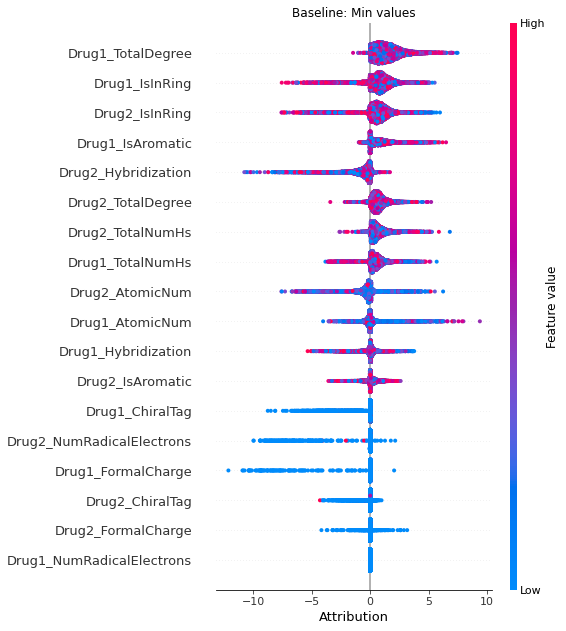

In [245]:
shap.summary_plot(concat_folds_min[:, :nr_drug_feat],
                  test_features[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline: Min values")
plt.xlabel("Attribution")
plt.show()

In [246]:
# shap.summary_plot(concat_folds_max[:, :nr_drug_feat],
#                   test_features[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Max values")
# plt.show()

In [247]:
# shap.summary_plot(concat_folds_min_max_avg[:, :nr_drug_feat],
#                   test_features[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min-Max avg. values")
# plt.show()

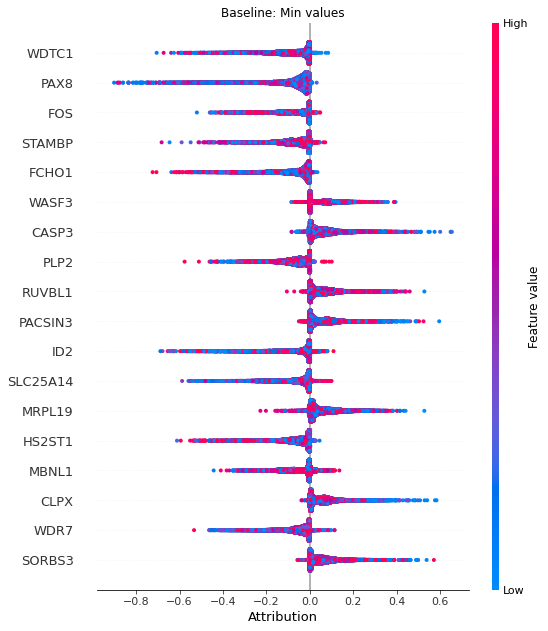

In [248]:
shap.summary_plot(concat_folds_min[:, nr_drug_feat:],
                  test_features[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False)
plt.title("Baseline: Min values")
plt.xlabel("Attribution")
plt.show()

In [249]:
# shap.summary_plot(concat_folds_max[:, nr_drug_feat:],
#                   test_features[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Max values")
# plt.show()

In [250]:
# shap.summary_plot(concat_folds_min_max_avg[:, nr_drug_feat:],
#                   test_features[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline: Min-Max avg. values")
# plt.show()

### Attributions 1s, 0s, separately

In [251]:
# shap.summary_plot(concat_folds_min_zeros[:, :nr_drug_feat],
#                   test_features_zeros[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline for 0's: Min values")
# plt.xlabel("Attribution")
# plt.show()

In [252]:
# shap.summary_plot(concat_folds_min_ones[:, :nr_drug_feat],
#                   test_features_ones[:, :nr_drug_feat],
#                   feature_names=all_feat[:nr_drug_feat],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline for 1's: Min values")
# plt.xlabel("Attribution")
# plt.show()

In [253]:
# shap.summary_plot(concat_folds_min_zeros[:, nr_drug_feat:],
#                   test_features_zeros[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline for 0's: Min values")
# plt.xlabel("Attribution")
# plt.show()

In [254]:
# shap.summary_plot(concat_folds_min_ones[:, nr_drug_feat:],
#                   test_features_ones[:, nr_drug_feat:],
#                   feature_names=all_feat[nr_drug_feat:],
#                   max_display=nr_drug_feat, show=False)
# plt.title("Baseline for 1's: Min values")
# plt.xlabel("Attribution")
# plt.show()

### Attributions for Cell Line

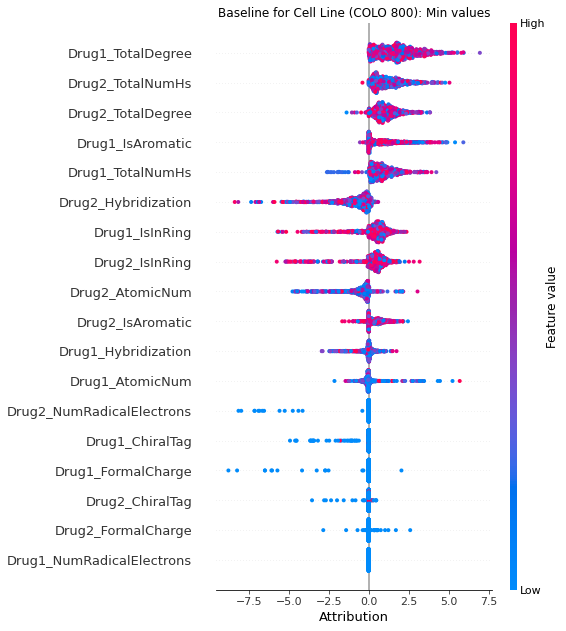

In [255]:
shap.summary_plot(concat_folds_min_CellLine[:, :nr_drug_feat],
                  test_features_CellLine[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False)
plt.title(f"Baseline for Cell Line ({sel_CellLine}): Min values")
plt.xlabel("Attribution")
plt.show()

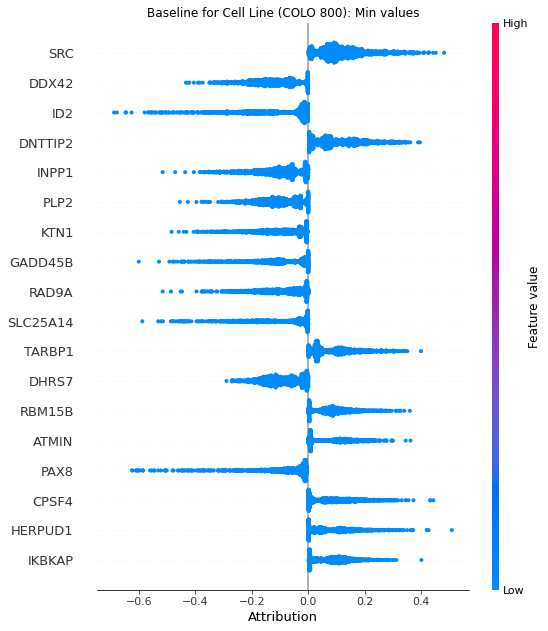

In [256]:
shap.summary_plot(concat_folds_min_CellLine[:, nr_drug_feat:],
                  test_features_CellLine[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False)
plt.title(f"Baseline for Cell Line ({sel_CellLine}): Min values")
plt.xlabel("Attribution")
plt.show()

### Attributions for Instance

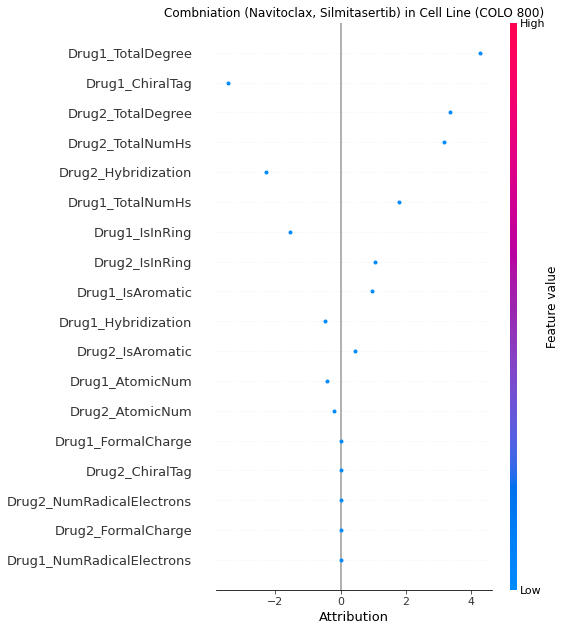

In [257]:
shap.summary_plot(concat_folds_min_Instance[:, :nr_drug_feat],
                  test_features_Instance[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False)
plt.title(f"Combniation ({sel_Drug1_ID}, {sel_Drug2_ID}) in Cell Line ({sel_CellLine})")
plt.xlabel("Attribution")
plt.show()

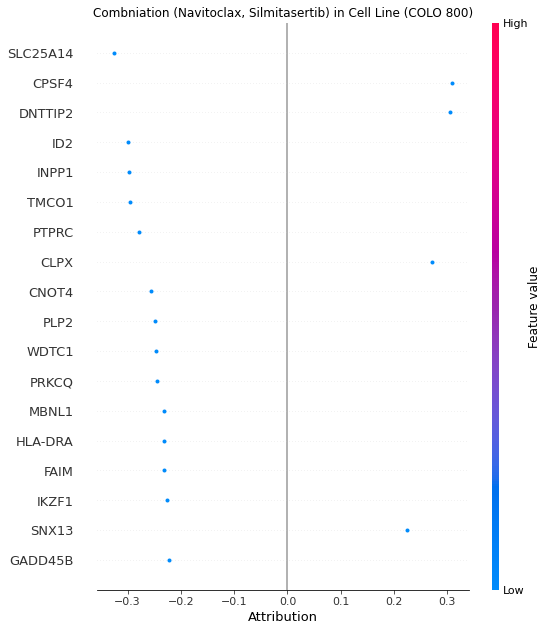

In [258]:
shap.summary_plot(concat_folds_min_Instance[:, nr_drug_feat:],
                  test_features_Instance[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False)
plt.title(f"Combniation ({sel_Drug1_ID}, {sel_Drug2_ID}) in Cell Line ({sel_CellLine})")
plt.xlabel("Attribution")
plt.show()